# Transistor Analysis in the Notebook

### Library imports

In [1]:
# numpy and plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Plotting Defaults (must come after other imports)
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True,
                 'xtick.top': True,
                 'xtick.direction': 'in',
                 'ytick.right': True,
                 'ytick.direction': 'in',
                 'font.sans-serif': 'Arial',
                 'font.size': 14,
                 'savefig.dpi': 300,
                 'figure.dpi': 96
                })

# Data handling
from glob import glob
import os
from os.path import join, basename, dirname, split
import pandas as pd

# Table of Contents <a name="toc"></a>
---

# 0. [Data Ingestion](#io)
# 1. [Transfer Curves](#xfer)
# 2. [Results Summaries](#results)
# 3. [Output Curves](#output)

---

# 0. Data Ingestion <a name="io"></a>
---

### Start by defining your data folder (where your .iv files are), and a figures folder to save any resulting figures.

In [2]:
data_folder = join('data','fet','180208nep2')
fig_folder = join('figures','fet','')
os.makedirs(fig_folder, exist_ok=True)
print(data_folder)

data/fet/180208nep2


You may need to "join" (look up `os.path.join`) additional levels of subdirectories (the '*') to get to your actual .iv files. In my case I stored them in "transfer" and "output" folders. So the list of files will have both transfer and output files at first. Also look up `glob.glob`, this is what returns the files.

In [3]:
devs = glob(join(data_folder,"*","*.iv"))
devs

['data/fet/180208nep2/output/180208nep2_out-12_B1.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_B2.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_B3.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_B4.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_B5.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_B6.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_B7.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_B8.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_D1.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_D2.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_D3.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_D4.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_D5.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_D6.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_D7.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_D8.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_F1.iv',
 'data/fet/180208nep2/output/180208nep2_out-12_F2.iv',
 'data/fet

## Read in raw data using pandas.read_table()

In [4]:
def read_iv(iv_file):
    
    """
    Loader and parser for .iv files
    Returns: dataframe of all sweeps
    and dataframe of the last sweep
    """
    
    raw_table = pd.read_csv(iv_file, sep='\t', header=None)
    raw_table = raw_table.drop(columns=0)
    num_sweeps = int(raw_table.columns.max()/6)

    dev_cols = pd.MultiIndex.from_product([[i+1 for i in range(num_sweeps)],
                                            ["vs","is","vd","id","vg","ig"]],
                                           names = ["sweep","smu"])

    raw_table.columns=dev_cols
    
    return raw_table, raw_table.loc[:,num_sweeps]

### `read_iv` gives back a pandas DataFrame, which acts like a table

The first returned value is the full table, the second returned value is just the table of the last sweep.

In [5]:
read_iv(devs[0])[0].head()

sweep   1                                             2                  \
smu     vs        is   vd        id    vg        ig   vs        is   vd   
0      0.0 -0.000005  0.0 -0.000042 -60.0 -0.000105  0.0  0.000056  0.0   
1      0.0 -0.000945  1.0  0.001050 -60.0 -0.000105  0.0 -0.000945  1.0   
2      0.0 -0.000945  2.0  0.001050 -60.0 -0.000105  0.0 -0.000945  2.0   
3      0.0 -0.000945  3.0  0.001050 -60.0 -0.000105  0.0 -0.000945  3.0   
4      0.0 -0.000945  4.0  0.001050 -60.0 -0.000105  0.0 -0.000945  4.0   

sweep              ...      12                             13                 \
smu          id    ...      vd        id    vg        ig   vs        is   vd   
0     -0.000142    ...     0.0 -0.000208  50.0  0.000105  0.0 -0.000069  0.0   
1      0.001050    ...     1.0  0.000945  50.0  0.000105  0.0 -0.001050  1.0   
2      0.001050    ...     2.0  0.000945  50.0  0.000105  0.0 -0.001050  2.0   
3      0.001050    ...     3.0  0.000945  50.0  0.000105  0.0 -0.001050  3.0   
4      0.001050    ...     4.0  0.000945  50.0  0.000105  0.0 -0.001050  4.0   

sweep                            
smu          id    vg        ig  
0     -0.000203  60.0  0.000105  
1      0.000945  60.0  0.000105  
2      0.000945  60.0  0.000105  
3      0.000945  60.0  0.000105  
4      0.000945  60.0  0.000105  

[5 rows x 78 columns]

### We also need to get out the channel letter/number

In [6]:
devs[0]

'data/fet/180208nep2/output/180208nep2_out-12_B1.iv'

In [8]:
def parse_iv(iv_file):
    
    """
    Reads iv file path and parses out:
    devName, mode, chan
    """
    
    chan = basename(iv_file).split('_')[-1][:-3]  # A1, B2, etc
    mode = split(dirname(iv_file))[1]  # transfer or output
    devName = split(dirname(dirname(iv_file)))[1]  # Name of device
    
    return devName, mode, chan

## Build master dataframe

In [47]:
### INSTANTIATE DATAFRAME AND PARSE NAME + SWEEPS ###
df = pd.DataFrame(devs, columns=["path"])
df[["name","mode","chan"]] = df.apply(lambda r: parse_iv(r["path"]), axis=1, result_type="expand")
df[["all", "last"]] = df.apply(lambda r: read_iv(r["path"]), axis=1, result_type="expand")
df.head()

,path,name,mode,chan,all,last
0,data/fet/180208nep2/output/180208nep2_out-12_B...,180208nep2,output,B1,sweep 1 ...,smu vs is vd id vg ...
1,data/fet/180208nep2/output/180208nep2_out-12_B...,180208nep2,output,B2,sweep 1 ...,smu vs is vd id vg ...
2,data/fet/180208nep2/output/180208nep2_out-12_B...,180208nep2,output,B3,sweep 1 ...,smu vs is vd id ...
3,data/fet/180208nep2/output/180208nep2_out-12_B...,180208nep2,output,B4,sweep 1 ...,smu vs is vd id ...
4,data/fet/180208nep2/output/180208nep2_out-12_B...,180208nep2,output,B5,sweep 1 ...,smu vs is vd id ...


### There are 8 different channel arrangements:

Basically three things need to be specified:
* is the top-left device horizontal or vertical
* is the top-left device 50 or 100 µm
* do orientations or channel lengths alternate down the rows?

For example: (horizontal, 50µm, lengths) would look like:

| Row, Col | A   | B   | C    |
|----------|-----|-----|------|
| 1        | h50 |  v50| h50  |
| 2        | h100| v100| h100 |
|  3       | h50 |  v50| h50  |

We need to generate that lookup table.

In [48]:
def layout_table(tl_orient, tl_len, row_alt):
    '''
    Given the top-left device orientation (h or v),
    top-left length (50 or 100),
    and which of these alternates down the rows (orient or len),
    Return an 8x8 array of orientations (h or v)
    and an 8x8 array of lengths (50e-6 or 100e-6)
    '''
    
    orients = np.array(['h','v'])
    lens = np.array([50,100])
    
    if row_alt=='orient':
        orient_mask = np.tile((orients!=tl_orient), (8,4)).astype(int).T
        len_mask = np.tile((lens!=tl_len), (8,4)).astype(int)
    else:
        orient_mask = np.tile((orients!=tl_orient), (8,4)).astype(int)
        len_mask = np.tile((lens!=tl_len), (8,4)).astype(int).T

    orient_array = np.vectorize(lambda ii: orients[ii])(orient_mask)
    len_array = np.vectorize(lambda ii: lens[ii])(len_mask)*1e-6
    
    return orient_array, len_array        

In [49]:
OA, LA = layout_table('v',100,'len')
OA, LA

(array([['v', 'h', 'v', 'h', 'v', 'h', 'v', 'h'],
        ['v', 'h', 'v', 'h', 'v', 'h', 'v', 'h'],
        ['v', 'h', 'v', 'h', 'v', 'h', 'v', 'h'],
        ['v', 'h', 'v', 'h', 'v', 'h', 'v', 'h'],
        ['v', 'h', 'v', 'h', 'v', 'h', 'v', 'h'],
        ['v', 'h', 'v', 'h', 'v', 'h', 'v', 'h'],
        ['v', 'h', 'v', 'h', 'v', 'h', 'v', 'h'],
        ['v', 'h', 'v', 'h', 'v', 'h', 'v', 'h']], dtype='<U1'),
 array([[1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04],
        [5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.e-05],
        [1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04],
        [5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.e-05],
        [1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04],
        [5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.e-05],
        [1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04],
        [5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.e-05, 5.

### Now, using these lookup tables, we can map our rows and columns to actual channel orientations and lengths

In [67]:
df['col'] = df['chan'].apply(lambda s: ord(s[0].lower())-97)  # Column letter -> column number 0-7
df['row'] = df['chan'].apply(lambda s: int(s[1])-1)  # row number -> 0-7
df['L'] = df.apply(lambda entry: LA[entry['row'], entry['col']], axis=1)  # Lookup length
df['orient'] = df.apply(lambda entry: OA[entry['row'], entry['col']], axis=1)  # Lookup orientation
df.head()

,path,name,mode,chan,all,last,col,row,L,W,gate_thick,dielectric,vg_lims,orient
0,data/fet/180208nep2/output/180208nep2_out-12_B...,180208nep2,output,B1,sweep 1 ...,smu vs is vd id vg ...,1,0,0.00010,0.001,6.500000e-07,2.1,"(40, 59)",h
1,data/fet/180208nep2/output/180208nep2_out-12_B...,180208nep2,output,B2,sweep 1 ...,smu vs is vd id vg ...,1,1,0.00005,0.001,6.500000e-07,2.1,"(40, 59)",h
2,data/fet/180208nep2/output/180208nep2_out-12_B...,180208nep2,output,B3,sweep 1 ...,smu vs is vd id ...,1,2,0.00010,0.001,6.500000e-07,2.1,"(40, 59)",h
3,data/fet/180208nep2/output/180208nep2_out-12_B...,180208nep2,output,B4,sweep 1 ...,smu vs is vd id ...,1,3,0.00005,0.001,6.500000e-07,2.1,"(40, 59)",h
4,data/fet/180208nep2/output/180208nep2_out-12_B...,180208nep2,output,B5,sweep 1 ...,smu vs is vd id ...,1,4,0.00010,0.001,6.500000e-07,2.1,"(40, 59)",h


### Finally, define the other parameters of your device architecture:
* Channel width
* gate dielectric constant
* gate thickness
* Limits on VG over which to fit mobility

In [68]:
chan_wid = 1e-3  # meters
diel_const = 2.1  # relative
gate_thick = 650e-9  # meters
vg_lims = (40,59) # volts

df['W'] = chan_wid
df['gate_thick'] = gate_thick
df['dielectric'] = diel_const
df['vg_lims'] = [vg_lims for i in df.index]  # Have to do this because vg_lims is a tuple
df.head()

,path,name,mode,chan,all,last,col,row,L,W,gate_thick,dielectric,vg_lims,orient
0,data/fet/180208nep2/output/180208nep2_out-12_B...,180208nep2,output,B1,sweep 1 ...,smu vs is vd id vg ...,1,0,0.00010,0.001,6.500000e-07,2.1,"(40, 59)",h
1,data/fet/180208nep2/output/180208nep2_out-12_B...,180208nep2,output,B2,sweep 1 ...,smu vs is vd id vg ...,1,1,0.00005,0.001,6.500000e-07,2.1,"(40, 59)",h
2,data/fet/180208nep2/output/180208nep2_out-12_B...,180208nep2,output,B3,sweep 1 ...,smu vs is vd id ...,1,2,0.00010,0.001,6.500000e-07,2.1,"(40, 59)",h
3,data/fet/180208nep2/output/180208nep2_out-12_B...,180208nep2,output,B4,sweep 1 ...,smu vs is vd id ...,1,3,0.00005,0.001,6.500000e-07,2.1,"(40, 59)",h
4,data/fet/180208nep2/output/180208nep2_out-12_B...,180208nep2,output,B5,sweep 1 ...,smu vs is vd id ...,1,4,0.00010,0.001,6.500000e-07,2.1,"(40, 59)",h


# 1. Transfer Curves <a name="xfer"></a>
---
[Back to TOC](#toc)

Let's get just the measurements of transfer curves.

In [72]:
xfer = df.loc[df['mode']=='transfer'].copy()
xfer.sample(3)

,path,name,mode,chan,all,last,col,row,L,W,gate_thick,dielectric,vg_lims,orient
66,data/fet/180208nep2/transfer/180208nep2-10_A3.iv,180208nep2,transfer,A3,sweep 1 ...,smu vs is vd id ...,0,2,0.00010,0.001,6.500000e-07,2.1,"(40, 59)",v
83,data/fet/180208nep2/transfer/180208nep2-10_E4.iv,180208nep2,transfer,E4,sweep 1 ...,smu vs is vd id ...,4,3,0.00005,0.001,6.500000e-07,2.1,"(40, 59)",v
103,data/fet/180208nep2/transfer/180208nep2-7_B8.iv,180208nep2,transfer,B8,sweep 1 ...,smu vs is vd id vg ...,1,7,0.00005,0.001,6.500000e-07,2.1,"(40, 59)",h


## Fit Mobility

Here we will define a function that takes the relevant parameters and returns mobility, threshold voltage, a regressor object and the Sirringhaus Reliability factor

In [73]:
from sklearn.linear_model import LinearRegression

def fit_saturation_mobility(vgate, idrain, W, L, gate_thickness, dielectric, vg_lims):
    
    """
    Inputs:
    -------
    vgate: array of gate voltages
    idrain: array of drain currents
    W: channel width in meters
    L: channel length in meters
    gate_thickness: in meters
    dielectric: DE constant (relative)
    vg_lims: lower and upper bound on VG to perform fit
    
    Returns:
    --------
    Mobility: in cm^2/Vs
    VT: threshold voltage
    reg: a sklearn estimator object, fitted to the data
    Rel: Sirringhaus reliability factor (scalar)    
    """
    
    # eps_rel * eps_0 / thickness gives capacitance per unit area in m^-2
    Cap = dielectric * 8.854e-12 / gate_thickness / (100**2)   # convert to F/cm^2
    
    fit_start = np.where(vgate>=vg_lims[0])[0][0]  # Find first instance where vg crosses the lower bound
    fit_stop = np.where(vgate>=vg_lims[1])[0][0]   # Find first instance where vg crosses the upper bound
    
    vg_range = vgate[fit_start:fit_stop].values.reshape(-1,1)
    id_range = np.sqrt(np.abs(idrain[fit_start:fit_stop])).values.reshape(-1,1)
    
    K = (W*Cap)/(2*L)   # Constant term in front of equation
    
    reg = LinearRegression()  # Instantiate Regressor
    reg.fit(vg_range,id_range)  # Fit to data
    
    M = reg.coef_[0][0]  # Get out the coefficients
    B = reg.intercept_[0]
    Mobility = M**2/K  # Compute mobility and VT
    VT = B/-M
    
    # Calculate reliability factor from Sirringhaus paper
    M_0 = (np.sqrt(np.abs(idrain[fit_stop]))-np.sqrt(np.abs(idrain[np.where(vgate==0)[0][0]]))) / vgate[fit_stop]
    Rel = M_0**2/M**2
    
    return Mobility, VT, reg, Rel

In [74]:
def get_metrics(row):
    """
    Wrapper function for metric fitting that
    operates on one row of the master dataframe
    
    Input: one row of a dataframe (meant to be used inside a .apply() lambda)
    Returns: pandas Series of metrics that can be
    broadcast back to master df from a .apply()
    """
    
    sweep = row['last']
    results = pd.Series()
#     turnaround = sweep['vg'].diff().diff().abs().idxmax()
    results['mob'], results['vt'], results['reg'], results['Rel'] = \
        fit_saturation_mobility(sweep['vg'], sweep['id'],
                                row['W'], row['L'],
                                row['gate_thick'], row['dielectric'],
                                row['vg_lims'])
    
    return results

In [75]:
xfer[['mob', 'vt', 'reg', 'rel']] = xfer.apply(get_metrics, axis=1, result_type='expand')
xfer.sample(3)

,path,name,mode,chan,all,last,col,row,L,W,gate_thick,dielectric,vg_lims,orient,mob,vt,reg,rel
69,data/fet/180208nep2/transfer/180208nep2-10_A6.iv,180208nep2,transfer,A6,sweep 1 ...,smu vs is vd id ...,0,5,0.00005,0.001,6.500000e-07,2.1,"(40, 59)",v,1.567599e-01,15.666580,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.506487
65,data/fet/180208nep2/transfer/180208nep2-10_A2.iv,180208nep2,transfer,A2,sweep 1 ...,smu vs is vd id vg ...,0,1,0.00005,0.001,6.500000e-07,2.1,"(40, 59)",v,2.527610e-07,-127703.890953,"LinearRegression(copy_X=True, fit_intercept=Tr...",3.644379
66,data/fet/180208nep2/transfer/180208nep2-10_A3.iv,180208nep2,transfer,A3,sweep 1 ...,smu vs is vd id ...,0,2,0.00010,0.001,6.500000e-07,2.1,"(40, 59)",v,1.420198e-01,10.937999,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.625547


### Results summary

Get just the juicy rows of the dataframe

In [79]:
result_rows = ['chan', 'L', 'orient', 'mob', 'vt', 'rel']
xfer[result_rows].groupby(('orient','L')).agg(['mean','std'])

/anaconda/envs/pyTen/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


mob                       vt                         rel  \
                    mean       std           mean           std          mean   
orient L                                                                        
h      0.00005  1.924655  1.074625   -1166.420162  3.355142e+03      0.658376   
       0.00010  1.341878  1.028377  279420.435035  1.153731e+06  10213.478356   
v      0.00005  0.158914  0.147359   -7847.401374  3.196530e+04      2.959081   
       0.00010  0.110713  0.054962  -77903.567629  3.117209e+05    695.149681   

                              
                         std  
orient L                      
h      0.00005      0.326911  
       0.00010  40846.934151  
v      0.00005      8.741364  
       0.00010   2778.624670

Obviously some entries are bad devices... these need to be filtered.

## Plot Transfer Curves

This function is a bit complicated, but it plots ID on a log scale in red and sqrt(ID) on linear scale in blue, plus a dashed line of the saturation regime fit.

In [81]:
%matplotlib notebook
def plot_tcurve_fit(row, color_lin='xkcd:cobalt blue', color_log='xkcd:indian red', color_fit='xkcd:dark gray'):
    
    sweep = row['last']
    
    fig, ax2 = plt.subplots(figsize=(5,4))

    ax2.plot(sweep['vg'], np.sqrt(sweep['id']), '.', markersize=3, color=color_lin, alpha=0.8)
    ax2.set_ylabel(r'$\sqrt{I_D}\:\:\:(\sqrt{A})$', color=color_lin)
    ax2.tick_params('y', colors=color_lin)
    ax2.set_xlabel(r'$V_G\:\:(V)$')
    
    vg_fit = np.linspace(row['vt'],max(row['vg_lims']),50)
    id_fit = row['reg'].predict(vg_fit.reshape(-1,1))
    ax2.plot(vg_fit, id_fit, '--', color=color_fit)

    ax1 = ax2.twinx()
    ax1.plot(sweep['vg'], sweep['id'], '.', markersize=3, color=color_log, alpha=0.8)
    ax1.set_yscale('log')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel(r'$I_D\:\:(A)$', color=color_log)
    ax1.tick_params('y', colors=color_log)

    fig.tight_layout()

<IPython.core.display.Javascript object>


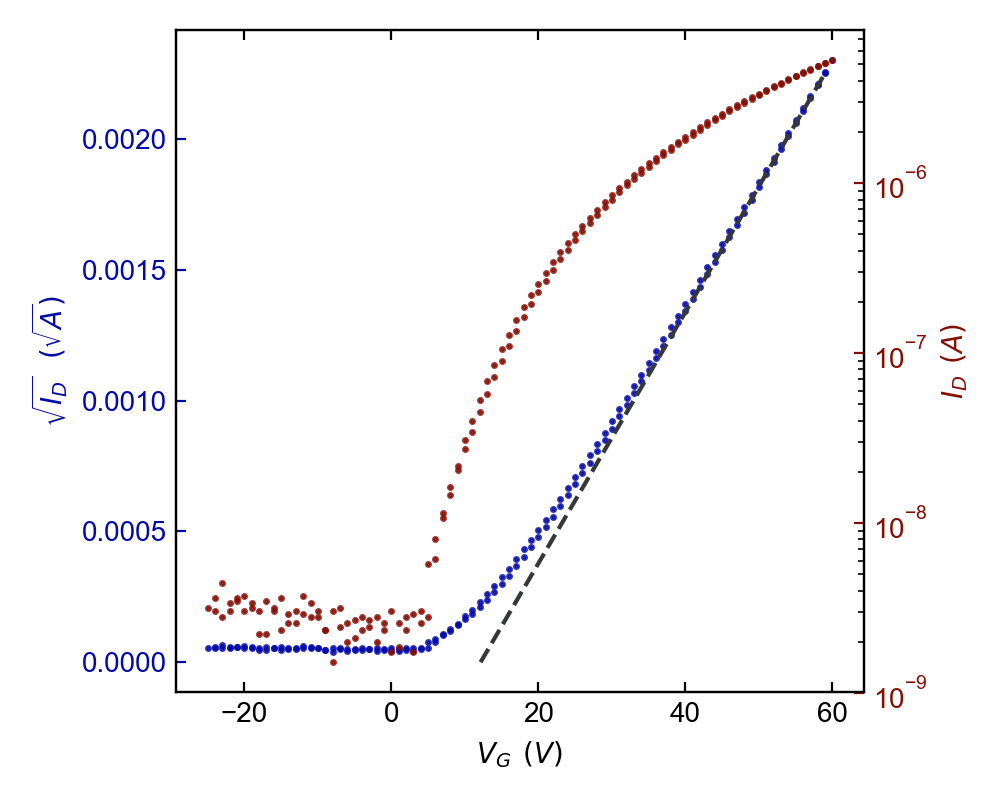

/anaconda/envs/pyTen/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


In [82]:
chan2plot = "E5"
chan_row = xfer.set_index('chan').loc[chan2plot]
plot_tcurve_fit(chan_row)
# plt.savefig('tol_hi_nogr_xfer_E5.png')

# 2. Results Summaries <a name="results"></a>
---
[Back to TOC](#toc)

In [83]:
# Using the transfer curve map created below, the good channels were identified

hi_good = ["F{}".format(i) for i in range(2,9)] + \
          ["D{}".format(i) for i in range(1,7)] + \
          ["B{}".format(i) for i in [3,4,5,6]] + \
          ["H5", "H6"] + \
          ["{}{}".format(c,i) for c in ['A','C'] for i in range(3,7)] + \
          ["E{}".format(i) for i in [3,5,6,8]] + \
          ["G3", "G4", "G5"]
        
print(hi_good)

['F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'B3', 'B4', 'B5', 'B6', 'H5', 'H6', 'A3', 'A4', 'A5', 'A6', 'C3', 'C4', 'C5', 'C6', 'E3', 'E5', 'E6', 'E8', 'G3', 'G4', 'G5']


### Group by orientation, then length, then apply mean and std

In [84]:
xfer_good = xfer.loc[xfer['chan'].isin(hi_good)].copy()
chan_len_stats = xfer_good[result_rows].groupby(['orient','L']).agg(('mean','std'))
chan_len_stats

mob                   vt                 rel          
                    mean       std       mean       std      mean       std
orient L                                                                   
h      0.00005  2.443463  0.591911  16.053704  2.268455  0.524568  0.053360
       0.00010  2.120930  0.269725  15.476606  3.082617  0.536614  0.074926
v      0.00005  0.169960  0.036418  13.503471  1.528870  0.576127  0.044786
       0.00010  0.146849  0.030283  12.957255  3.548504  0.584422  0.086271

### Make bar plots

<IPython.core.display.Javascript object>


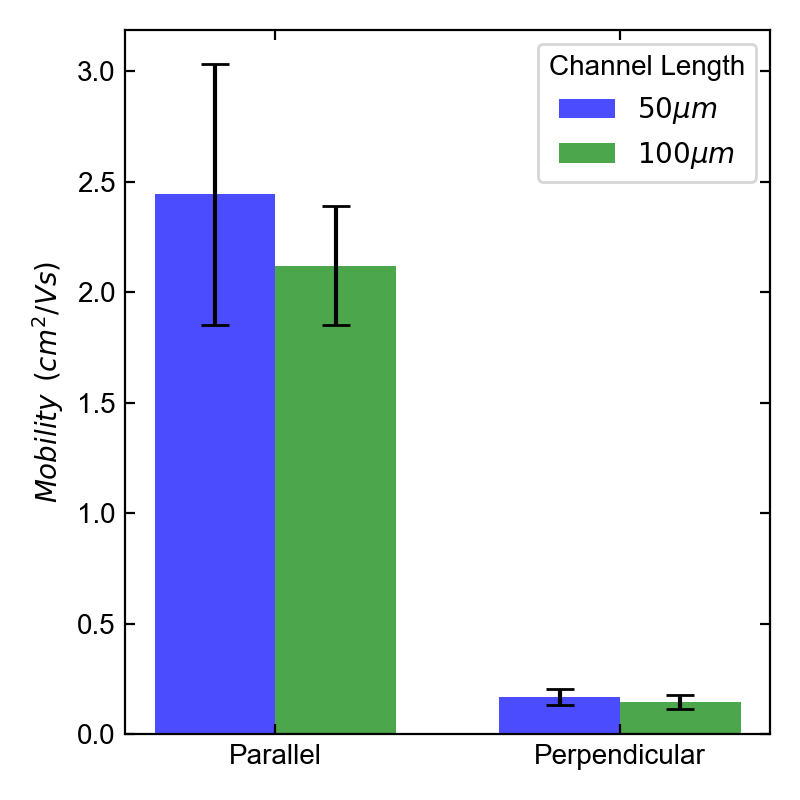

In [85]:
N = 2

fig, ax = plt.subplots(figsize=(4,4))

ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, chan_len_stats.iloc[[0,2]][('mob','mean')],
            yerr=chan_len_stats.iloc[[0,2]][('mob','std')],
            width=width, color='b', alpha=0.7, capsize=5)

p2 = ax.bar(ind + width, chan_len_stats.iloc[[1,3]][('mob','mean')],
            yerr=chan_len_stats.iloc[[1,3]][('mob','std')],
            width=width, color='g', alpha=0.7, capsize=5)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Parallel', 'Perpendicular'))

ax.legend((p1[0], p2[0]), ('$50 \mu m$', '$100 \mu m$'), title="Channel Length")
plt.ylabel('$Mobility \:\: (cm^2/Vs)$')
plt.tight_layout()
# plt.savefig('tol_hi_nogr_chan_len_stats.png')

<IPython.core.display.Javascript object>


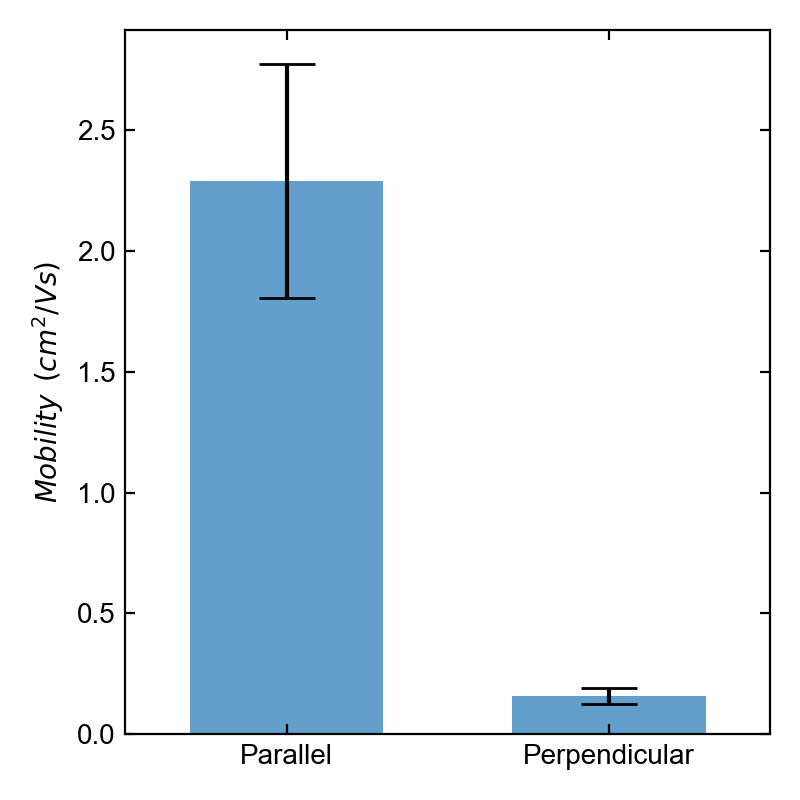

In [87]:
gb_dir = xfer_good[['chan','mob','orient']].groupby('orient')['mob']

fig, ax = plt.subplots(figsize=(4,4))
ax.bar(gb_dir.agg('count').index.values,
       gb_dir.agg('mean'),
       yerr=gb_dir.agg('std'),
       alpha=0.7,
       align='center',
       width=0.6,
       ecolor='black',
       capsize=10)

ax.set_xlim([-0.5,1.5])
ax.set_ylabel('$Mobility \:\: (cm^2/Vs)$')
ax.set_xticklabels(['Parallel','Perpendicular'])

# Save the figure and show
plt.tight_layout()
# plt.savefig('tol_hi_nogr_para_vs_perp.png')

### Calculate $S_2D$

In [89]:
gb_dir_all = xfer_good[['chan','mob','orient']].groupby('orient')[['mob']]
gb_dir_all.describe()

mob                                                              \
       count      mean       std       min       25%       50%       75%   
orient                                                                     
h       19.0  2.290684  0.484653  1.569671  1.960333  2.212279  2.416322   
v       15.0  0.157634  0.034196  0.080920  0.143249  0.153161  0.168105   

                  
             max  
orient            
h       3.601693  
v       0.238396

In [90]:
rr=2.29/.1576
(rr-1)/(rr+1)

0.8712207877104102

# 3. Output Curves <a name="output"></a>
---
[Back to TOC](#toc)

In [91]:
chan2plot = "D5"
df_out = df.loc[df['mode']=='output'].copy()
sweeps = df_out.loc[df_out['chan']==chan2plot,"all"].iloc[0]
sweeps.loc[:,1].iloc[-1]['id']

2.56114e-09

In [92]:
def interp_cmap(values, cmap_name='viridis'):
    
    cmap = np.array(cm.get_cmap(cmap_name).colors)
    
    values_scaled = (values - np.min(values))/(np.max(values)-np.min(values))
    
    custom_cmap = \
    np.array([np.interp(values_scaled,
                      np.array(range(cmap.shape[0]))/cmap.shape[0],
                      cvec[:,0]) \
              for cvec in np.split(cmap,cmap.shape[1],axis=1)]).transpose()
    
    return custom_cmap

<IPython.core.display.Javascript object>


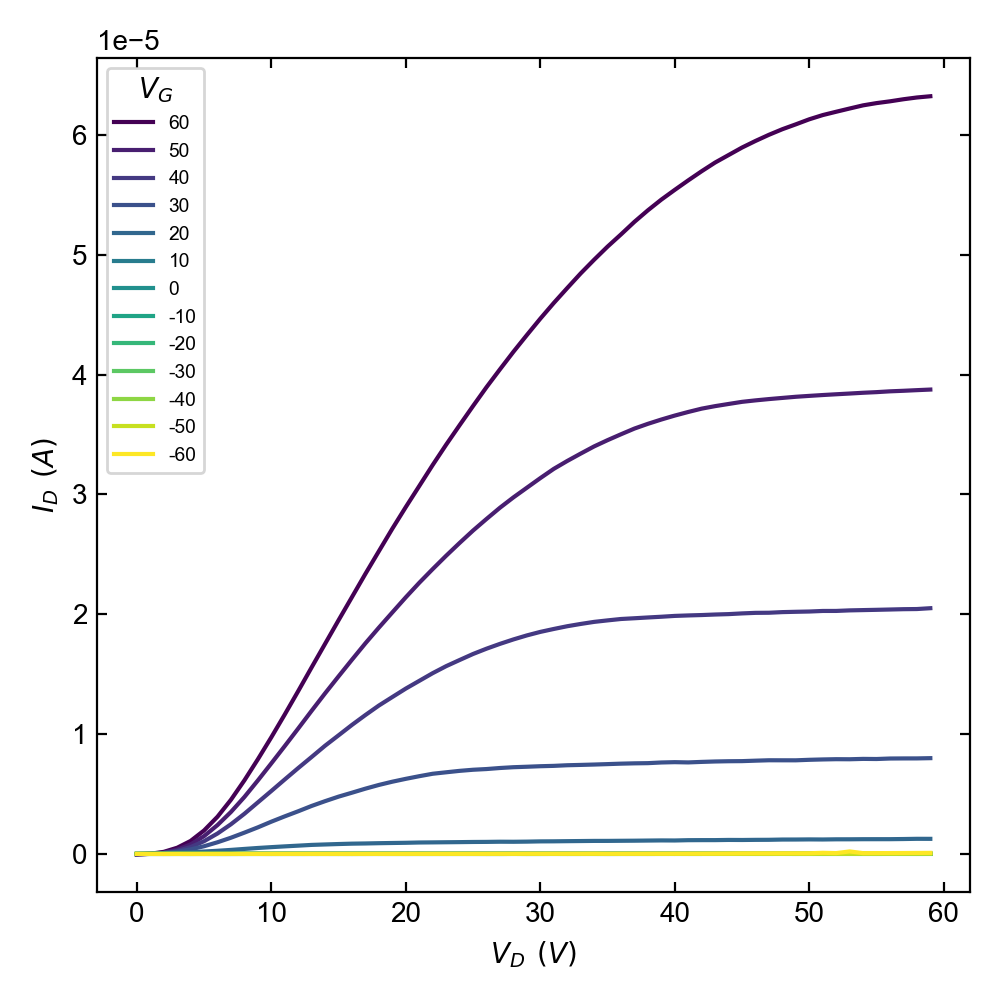

In [93]:
def plot_output(sweeps_df, newfig=True):
    
    fig = plt.figure(figsize=(5,5))
    sweeps_list = sweeps_df.columns.levels[0].values
    vg_list = []
    
    custom_cmap = interp_cmap(np.array(range(len(sweeps_list))),
                              cmap_name='viridis_r')
    
    for i in sweeps_list[::-1]:
        sdf = sweeps_df.loc[:,i]
        plt.plot(sdf.iloc[:-1]['vd'],
                 sdf.iloc[:-1]['id'],
                 color=custom_cmap[i-1,:],
                 label=str(int(sdf.iloc[0]['vg'])))
        
    ax1 = plt.gca() 
    ax1.set_ylabel(r'$I_D\:\:(A)$')
    ax1.set_xlabel(r'$V_D\:\:(V)$')
    ax1.ticklabel_format(style='sci',scilimits=(0,2))
    plt.legend(loc='upper left', fontsize='x-small', title=r'$V_G$', labelspacing=0.5)
    fig.tight_layout()

%matplotlib notebook
plot_output(sweeps)
# plt.savefig('tol_hi_para_output_D5.png')

# Generate figures for map plot

This is advanced-level stuff

In [50]:
%matplotlib inline
from os import makedirs
xfer_chans = xfer.set_index('chan')

tfig_folder = join(split(split(xfer_chans.loc["A1","path"])[0])[0],"figures","transfer")
makedirs(tfig_folder,exist_ok=True)
fig_urls = pd.Series()

for i,row in xfer.iterrows():
    fig_file = join(tfig_folder, row['chan']+".png")
    fig_url = "file:\\\\\\"+fig_file
    fig_urls.loc[i]=fig_url
#     sweep = row['last']
#     plot_tcurve_fit(row)
#     plt.savefig(fig_file, dpi=120)
#     plt.close()

In [51]:
xfer['file_url']=fig_urls

In [52]:
df_outchans = df_out.set_index('chan')
ofig_folder = join(split(split(df_outchans.loc["A1","path"])[0])[0],"figures","output")
makedirs(ofig_folder,exist_ok=True)
ofig_urls = pd.Series()

for i,row in df_out.iterrows():
    ofig_file = join(ofig_folder, row['chan']+".png")
    ofig_url = "file:\\\\\\"+ofig_file
    ofig_urls.loc[i]=ofig_url
#     sweep = row['all']
#     plot_output(sweep)
#     plt.savefig(ofig_file, dpi=120)
#     plt.close()

In [53]:
df_out['file_url']=ofig_urls

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [54]:
ofig_urls.iloc[0][8:]

'F:\\N2200 Project\\data\\fet\\top\\180208nep2\\figures\\output\\B1.png'

In [55]:
xfer['color_mob'] = ['rgb'+str(tuple((rgb*255).astype(int))) for rgb in interp_cmap(xfer['mob'].values)]
df_out['color_mob'] = xfer['color_mob'].copy()

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [56]:
def zoom_img_plot(df,x_col,y_col,image_col,x_label='X',y_label='Y',plot_width = 400, plot_height=400):
    
    tester = io.imread(df[image_col].iloc[0][8:])
    pix_h = tester.shape[0]
    pix_w = tester.shape[1]
    max_dim = max(pix_h, pix_w)
    data_h = pix_h/max_dim
    data_w = pix_w/max_dim
    
    p=figure(sizing_mode='scale_height',
             x_axis_label = x_label,
             y_axis_label = y_label,
             width = plot_width,
             height = plot_height,
             active_scroll = 'wheel_zoom',
             match_aspect=True
            )
    
    x_range = df[x_col].max()-df[x_col].min()
    y_range = df[y_col].max()-df[y_col].min()

    cds = bokeh.models.ColumnDataSource(
        df
    )
    
    circles = p.square(
        source=cds,
        x=x_col,
        y=y_col,
        size=40,
        fill_alpha=0.5,
        fill_color='color_mob'
    )

    p.add_tools(
        bokeh.models.HoverTool(
            tooltips=[
                ('Mobility', '@mob'),
                ('VT','@vt'),
                ('Channel','@chan')
            ]
        )
    )

    images = p.image_url(
        source=cds,
        x=x_col,
        y=y_col,
        w=data_w,
        h=data_h,
        w_units='data',
        h_units='data',
        url=image_col,
        anchor='center',
        global_alpha=0.2
    )

    p.x_range.callback = bokeh.models.CustomJS( args= {
            'x_axis': p.x_range,
            'y_axis': p.y_range,
            'images': images.glyph,
            'ddata': df[y_col].max()-df[y_col].min(),
            'points': p.renderers[5].glyph
        }, 
        code=coffee.compile("""
        dy = y_axis.end - y_axis.start
        if dy/ddata > .0001
            images['global_alpha']=.001 + (1)*Math.exp( -1*Math.pow(dy/ddata-.001,2)/.7)
        """,bare=True)
    )
    
    p.xaxis.axis_label_text_font_size = "16pt"
    p.yaxis.axis_label_text_font_size = "16pt"
    p.xaxis.major_label_text_font_size = "14pt"
    p.yaxis.major_label_text_font_size = "14pt"
    
    return p
    


In [57]:
output_file('transfer_map.html')
reset_output()
p = zoom_img_plot(xfer[['row','col','file_url','mob','vt','chan','color_mob']].copy(),'col','row','file_url',x_label='X',y_label='Y',plot_width=800,plot_height=500)
show(p)

In [34]:
output_file('output_map.html')
reset_output()
p = zoom_img_plot(df_out[['row','col','file_url','color_mob']].copy(),'col','row','file_url',x_label='X',y_label='Y',plot_width=800,plot_height=500)
show(p)